In [21]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum neptune-client
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .
    neptun_token = "" # put manually for the time being
else:
    import subprocess
    def get_var(varname):
        CMD = 'echo $(source ~/.bash_profile; echo $%s)' % varname
        p = subprocess.Popen(CMD, stdout=subprocess.PIPE, shell=True, executable='/bin/bash')
        return p.stdout.readlines()[0].strip()
    neptun_token = get_var('NEPTUNE_API_TOKEN').decode("utf-8") 

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
use_neptune = False

In [24]:
import neptune
import tensorflow as tf
import random

import io
import cirq
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from qsgenerator import circuits
from qsgenerator.quwgans import circuits as quwgans_circuits
from qsgenerator.quwgans.circuits import get_discriminator
from qsgenerator.quwgans.training import Trainer
from qsgenerator.phase.circuits import PhaseCircuitBuilder
from qsgenerator.states.butterfly_circuits import ButterflyCircuitBuilder
from qsgenerator.quwgans.real_expectations_provider import PrecomputedExpectationsProvider, \
    Interpolation1DExpectationsProvider, WassersteinGanExpectationProvider, ExpectationProviderType
from qsgenerator.states.simple_rotation_generators import get_fixed_random_rotation_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator
from qsgenerator.phase.analitical import get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider


In [31]:
generator_layers = 3
data_bus_size = 6
rank = 1
real_circuit_type = 'phase'
g_values = [-0.1]
generic_generator = False
zxz = False
all_gates_parametrized = False
expectation_provider_type = ExpectationProviderType.WGAN
known_g_values = np.linspace(-1,0,11)
# known_g_values = [-1, -0.75, -0.5, -0.25, 0]
if expectation_provider_type == ExpectationProviderType.WGAN:
        gen_input_dim = 10
        hidden_dim = 32
        penalty_factor = 10
        gan_epochs = 5000
        batch_size = 4
known_g_values

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ])

In [32]:
data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)

In [33]:
if real_circuit_type == 'butterfly':
    real, real_symbols = ButterflyCircuitBuilder().build(qubits=qubits)
    real_values_provider = get_fixed_random_rotation_provider(len(real_symbols))
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=False)
    real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
    real_values_provider = get_g_parameters_provider()

In [34]:
if generic_generator:
    gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
    symbols_dict_gen = {}
else:
    builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
    gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)

In [35]:
print("REAL GROUND STATE")
real

REAL GROUND STATE


(0, 0): ───H───@─────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │                         │
(0, 1): ───────X───Z───Ry(theta_r)───H───X───H───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                               │                                       │
(0, 2): ─────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                               │                                       │
(0, 3): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                               │                                       │
(0, 4): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                                                                                                               │                                       │
(0, 5): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta_w)───X───X───Ry(theta_w)───X───Ry(theta_v)───X───X───Ry(theta_v)───X───

In [36]:
print("GENERATOR")
gen

GENERATOR


(0, 0): ───H───@────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
               │                        │
(0, 1): ───────X───Z───Ry(theta0)───H───X───H───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                             │                                     │
(0, 2): ────────────────────────────────────────Ry(theta3)───X───X───Ry(theta4)───X───Ry(theta1)───X───X───Ry(theta2)───X───X────────────@───X─────────────────────────────────@───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                         │                                     │
(0, 3): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta7)───X───X───Ry(theta8)───X───Ry(theta5)───X───X───Ry(theta6)───X───X─────────────@───X──────────────────────────────────@───X─────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                      │                                      │
(0, 4): ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta11)───X───X───Ry(theta12)───X───Ry(theta9)───X───X───Ry(theta10)───X───X─────────────@───X───────────────────────────────────@───X─────────────────────
                                                                                                                                                                                                                                                                                                     │                                       │
(0, 5): ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Ry(theta15)───X───X───Ry(theta16)───X───Ry(theta13)───X───X───Ry(theta14)───X───

In [37]:
opt = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [40]:
def get_expectation_provider():
    precomputed_expectation_provider = PrecomputedExpectationsProvider(real,
                                                                       real_symbols,
                                                                       known_g_values,
                                                                       real_values_provider,
                                                                       get_discriminator(real))
    if expectation_provider_type == ExpectationProviderType.ONLY_KNOWN:
        return precomputed_expectation_provider
    elif expectation_provider_type == ExpectationProviderType.INTERPOLATION1D:
        return Interpolation1DExpectationsProvider(precomputed_expectation_provider)
    elif expectation_provider_type == ExpectationProviderType.WGAN:
        return WassersteinGanExpectationProvider(precomputed_expectation_provider, gen_input_dim, hidden_dim, penalty_factor, epochs, batch_size)

In [41]:
real_expectations_provider = get_expectation_provider()

In [42]:
trainer = Trainer(real, 
                  real_symbols,
                  gen,
                  gs,
                  g_values,
                  real_values_provider,
                  real_expectations_provider,
                  rank=rank,
                  use_neptune=use_neptune)

In [43]:
epochs = 501
gen_iteration = 1
snapshot_interval_epochs = 100

In [44]:
def start_neptune_experiment():
    if use_neptune:
        neptune.init(project_qualified_name='wiktor.jurasz/thesis-em', api_token=neptun_token)
        neptun_params = {
            'generator_layers': generator_layers,
            'size':  data_bus_size,
            'rank': rank,
            'real_circuit_type': real_circuit_type,
            'generic_generator': generic_generator,
            'zxz': zxz,
            'all_gates_parametrized': all_gates_parametrized,
            'g_values': g_values,
            'expectation_provider_type': expectation_provider_type,
            'known_g_values': known_g_values,
            'gen_iteration': gen_iteration,
            'epochs': epochs
        }
        if expectation_provider_type == ExpectationProviderType.WGAN:
            gan_params = {
                'gen_input_dim': gen_input_dim,
                'hidden_dim': hidden_dim,
                'penalty_factor': penalty_factor,
                'gan_epochs': gan_epochs,
                'batch_size': batch_size
            }
            neptun_params = {**neptun_params, **gan_params}
        neptune.create_experiment(name=None, description=None, params=neptun_params)
        neptune.log_artifact(io.StringIO(str(gen)), "gen.txt")
        neptune.log_artifact(io.StringIO(str(([(el[0].numpy(), el[1], list(el[2].numpy())) for el in trainer.gen_weights]))), 'init_gen_weights.txt')

In [45]:
start_neptune_experiment()

<Figure size 432x288 with 0 Axes>

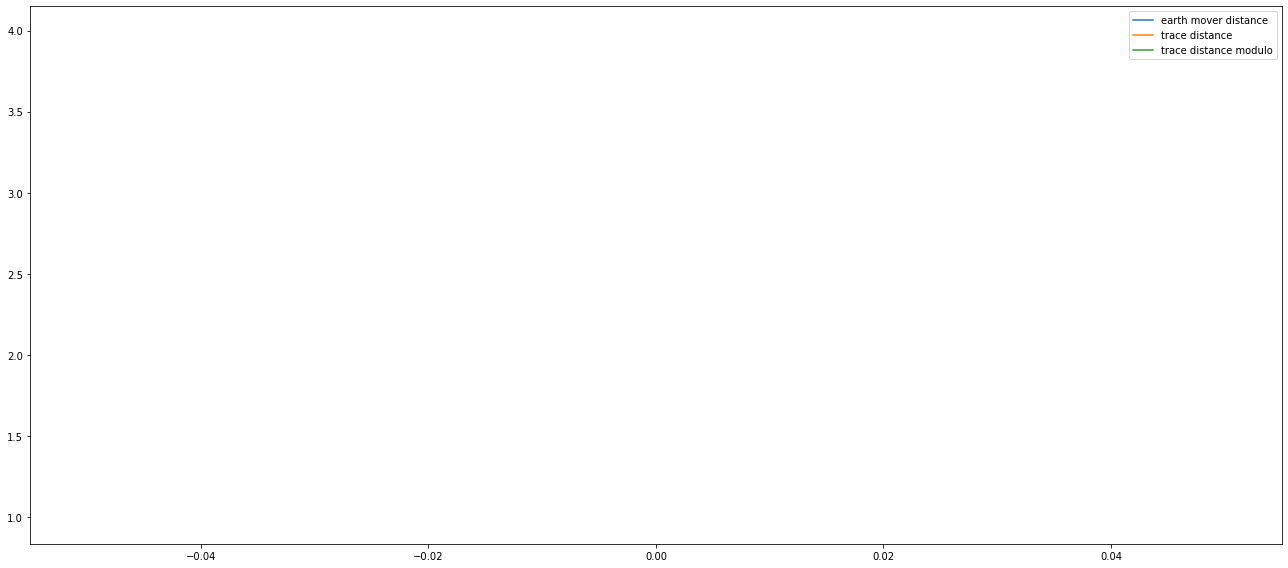

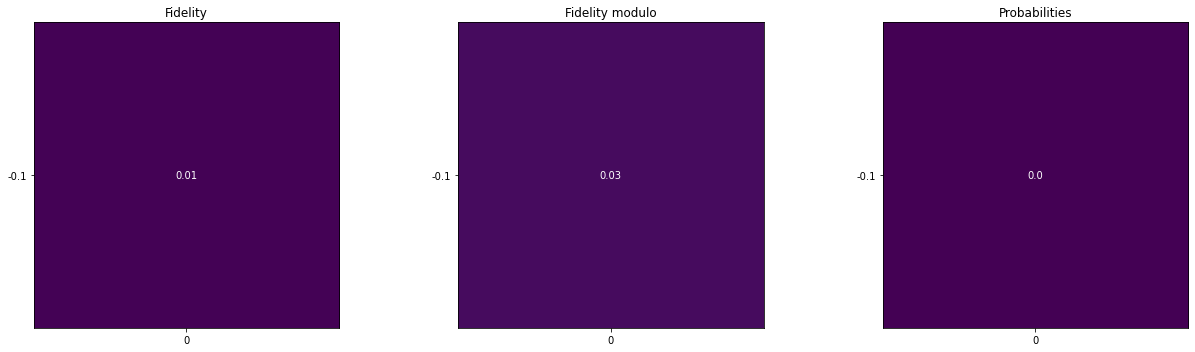

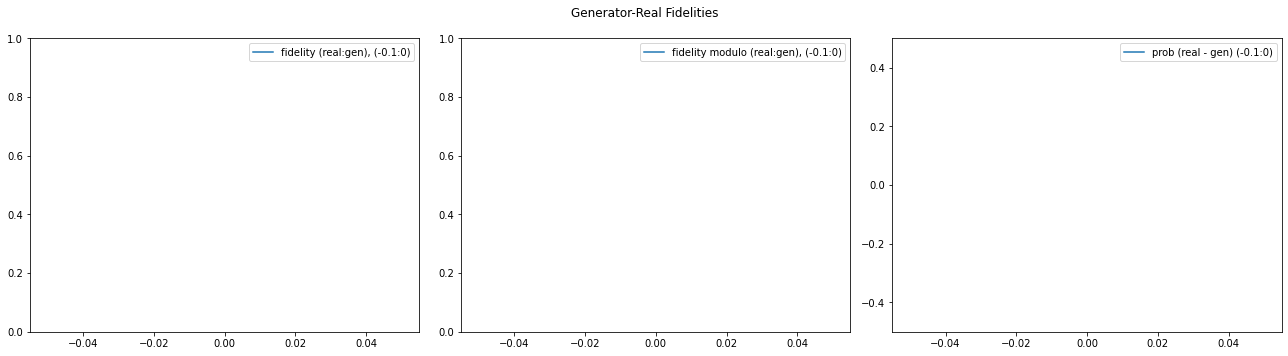

----------------------------------------------------
Epoch 0:  EM distance = 3.9986460189262116, trace distance = 0.9965361123801527, abs trace distance = 0.9857366913641515
h=X((0, 0))*X((0, 1)), w=0.9999827200966088, e=0.9999049811957675
h=Y((0, 0))*Y((0, 1)), w=1.7257062346657243e-05, e=0.9998212374152344
h=Z((0, 2)), w=0.9999999993812865, e=0.9998141325563233
h=Z((0, 4)), w=0.999999999381514, e=0.9999858753940358
h=Z((0, 3)), w=0.9999999993819556, e=0.9989406389741495
h=Y((0, 5)), w=0.9948238787416962, e=4.19113831156892e-07
Instructions for updating:
Use fn_output_signature instead


In [ ]:
json_result = trainer.train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)

In [ ]:
from scipy.optimize import linprog
def get_em_distance(W, H, t):
    traces = (t.get_all_generator_expectations(H).numpy() - t.get_real_expectation(H)).flatten()
    return sum(x * y for x, y in zip(W, traces))

def get_em_distance_real(t1, t2):
    traces = (t1.get_real_expectation(t1.disc_hamiltonians) - t2.get_real_expectation(t2.disc_hamiltonians)).flatten()
    res = linprog(-traces, A_ub=t1.A, b_ub=t1.b, bounds=(0, 1))
    tt = [traces[i] for i in range(len(t1.disc_hamiltonians)) if res.x[i] > 1.e-5]
    res2 = [res.x[i] for i in range(len(res.x)) if res.x[i] > 1.e-5]
    return sum(x * y for x, y in zip(res2, tt))

def get_em_distance2(W, H, t):
    traces = (t.get_all_generator_expectations(t.disc_hamiltonians).numpy() -
              t.get_real_expectation(t.disc_hamiltonians)).flatten()
    res = linprog(-traces, A_ub=t.A, b_ub=t.b, bounds=(0, 1))
    tt = [traces[i] for i in range(len(t.disc_hamiltonians)) if res.x[i] > 1.e-5]
    res2 = [res.x[i] for i in range(len(res.x)) if res.x[i] > 1.e-5] 
    return sum(x * y for x, y in zip(res2, tt)), res2, tt

def plot_em_distance_between_real():
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
    # g=-0.4
    # W, H = list(zip(*g_dict[g].last_run_generator_weights[-1].disc_w_h.items()))
    # get_em_distance(W, H, g_dict[-0.5]), g_dict[g].last_run_generator_weights[-1].em_distance
    g_values2 = [np.round(el, 1) for el in np.linspace(-1,0,11)]
    tr = {}
    for g in g_values2:
        tr[g] = Trainer(real, real_symbols, gen, gs, [g], real_values_provider, rank=rank, use_neptune=False)
    x = g_values2
    for g1 in g_values2:
        tmp_res = []
        for g2 in g_values2:
            tmp_res.append(get_em_distance_real(tr[g1], tr[g2]))
        axes.plot(x, tmp_res,label=g1)
    axes.legend()
    plt.show()

In [ ]:
plot_em_distance_between_real()

In [ ]:
generator_layers = 3
data_bus_size = 6
rank = 1
real_circuit_type = 'phase'
generic_generator = False
zxz = False
all_gates_parametrized = False
g_values = [-0.8]
sizes = [3,4,5,6,7,8]
epochs = 801
gen_iteration = 2
snapshot_interval_epochs = 200
expectation_provider_type = ExpectationProviderType.GAN
known_g_values = [-1,-0.75,-0.5,-0.25,0]

In [ ]:
# g_values = [-0.5, -0.5, -0.5, -0.5, -0.5, -0.4, -0.4, -0.4, -0.4, -0.4]
training_result = {}
trainer_dict = {}
for j, g in enumerate(g_values):
    trainer_by_size = {}
    result_by_size = {}
    training_result[(j, g)] = result_by_size
    trainer_dict[(j, g)] = trainer_by_size
    for i, data_bus_size in enumerate(sizes):
        data_qubits = qubits = cirq.GridQubit.rect(1, data_bus_size)
        
        start_neptune_experiment()
        
        if real_circuit_type == 'butterfly':
            real, real_symbols = ButterflyCircuitBuilder().build(qubits=qubits)
            real_values_provider = get_fixed_random_rotation_provider(len(real_symbols))
        else:
            builder = PhaseCircuitBuilder(all_gates_parametrized=False)
            real, real_symbols, symbols_dict_real = builder.build_ground_state_circuit(qubits=data_qubits)
            real_values_provider = get_g_parameters_provider()

        if generic_generator:
            gen, gs = circuits.build_circuit(generator_layers, data_qubits, "g")
            symbols_dict_gen = {}
        else:
            builder = PhaseCircuitBuilder(all_gates_parametrized=all_gates_parametrized)
            gen, gs, symbols_dict_gen = builder.build_ground_state_circuit(qubits=data_qubits, full_parametrization=True, zxz=zxz)
        real_expectations_provider = get_expectation_provider()
        trainer_by_size[(i, data_bus_size)] = Trainer(real, 
                                                      real_symbols, 
                                                      gen, 
                                                      gs, 
                                                      [g], 
                                                      real_values_provider, 
                                                      real_expectations_provider,
                                                      rank=rank, 
                                                      use_neptune=False)
        
        opt = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
        json_result = trainer_by_size[(i, data_bus_size)].train(opt, epochs, gen_iteration, snapshot_interval_epochs, plot=True)
        training_result[(i,data_bus_size)] = json_result


In [ ]:
if use_neptune:
    neptune.stop()

In [ ]:
# print fidelities of each generator
# get all hamiltonians of each discriminator (final iteration) - r
r = defaultdict(lambda: defaultdict(list))
# rg = defaultdict(lambda: defaultdict(list))
for j, g in enumerate(g_values):
    for i, s in enumerate(sizes):
        print(f"({j},{g}), ({i}, {s})" \
              f"abs_fidelity: {trainer_dict[(j, g)][(i, s)].last_run_generator_weights[-1].fidelities[0].abs_fidelity}")
        for k,v in trainer_dict[(j, g)][(i, s)].last_run_generator_weights[-1].disc_w_h.items():
            r[g][str(v)].append(i)
            r["COMBINED"][str(v)].append(i)
#             if g_dict[(i, g)].last_run_generator_weights[-1].trace_distance > 0.9:
#                 rg[g][str(v)].append(i)
r

In [ ]:
np.set_printoptions(suppress=True)
def get_expectations_real(g, t):
    full_weights = tf.keras.layers.Layer()(
                tf.Variable(np.array(t.real_values_provider(g), dtype=np.float32)))
    full_weights = tf.reshape(full_weights, (1, full_weights.shape[0]))
    exps = t.real_expectation([t.real],
                                         symbol_names=t.real_symbols,
                                         symbol_values=full_weights,
                                         operators=t.disc_hamiltonians)
    return {h: e for e, h in zip(exps.numpy()[0], [str(h) for h in t.disc_hamiltonians])}

def get_expectations_gen(g, t):
    full_weights = tf.keras.layers.Layer()(t.gen_weights[0][2])
    full_weights = tf.reshape(full_weights, (1, full_weights.shape[0]))
    exps = t.gen_expectation([t.gen],
                                         symbol_names=t.gs,
                                         symbol_values=full_weights,
                                         operators=t.disc_hamiltonians)
    return {h: e for e, h in zip(exps.numpy()[0], [str(h) for h in t.disc_hamiltonians])}

def get_exps(g_list, trainer, eps=1e-3):
    res = defaultdict(list)
    for g in g_list:
        for e in (fe for fe in get_expectations_real(g, trainer).items() if abs(float(fe[1])) >= eps):
            res[e[0]].append(e[1])
    return res

def get_exp(g, trainer, eps=1e-3):
    res = defaultdict(list)
    for e in (fe for fe in get_expectations_real(g, trainer).items() if abs(float(fe[1])) >= eps ):
        res[e[0]].append(e[1])
    return res

In [ ]:
# plot change in the expectation per pauli string
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
g_values_list = [0,1]
# random.shuffle(g_values_list)
es = get_exps(g_values_list, trainer_dict[(0, -0.8)][(0, 3)])
res = []
for k, v in es.items():
    c = []
    for i in range(len(v)):
          c.append(float(v[i]))
    res.append(c)
    x = list(range(len(c)))
    axes.plot(x, c,label=k)
axes.legend()
plt.show()
es

In [ ]:
# plots expecation change for different g for all pauli string with expecation higher than eps
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))
g_values_list = [np.round(el, 3) for el in np.linspace(-1,0,11)]
x_indexes = False
print(g_values_list)
# random.shuffle(g_values_list)
eps = 1.e-1
res = defaultdict(list)
for g in g_values_list:
    exps = get_exp(g, trainer, eps=0)
    for pauli_string, exp in exps.items():
        res[pauli_string].append(float(exp[0]))
curated_res = {k: v for k, v in res.items() if any(abs(el) > eps for el in res[k])}
for pauli_string, exp in curated_res.items():
    if x_indexes:
        axes.plot(range(len(g_values_list)), exp,label=pauli_string)
    else:
        axes.plot(g_values_list, exp,label=pauli_string) 
axes.legend()
axes.set_xlabel("g")
axes.set_ylabel("expectation")
plt.show()  

In [ ]:
# calculates expectations of each pauli string for all sizes of circuits
circuits_gen = []
circuits_real = []
size_to_exps_real = {}
size_to_exps_gen = {}
g = -0.8
eps = 1.e-5
for j, g in enumerate(g_values):
    for i, s in enumerate(sizes):
        tr = trainer_dict[(j, g)][(i, s)]
        size_to_exps_real[s] = get_expectations_real(g, tr)
        size_to_exps_gen[s] = get_expectations_gen(g, tr)
        circuits_gen.append(tr.gen_evaluator.get_all_resolved_circuits()[0][2])
        circuits_real.append(tr.real_evaluator.get_all_resolved_circuits()[0][2])
string_to_exp = defaultdict(list)
for s, exps_real in size_to_exps_real.items():
    exps_gen = size_to_exps_gen[s]
    for pauli_string, exp_real in exps_real.items():
        exp_gen = exps_gen[pauli_string]
        string_to_exp[pauli_string].append((exp_real, exp_gen))
curated_string_to_exp = {k: v for k, v in string_to_exp.items() if any(abs(float(el[0])) > eps for el in string_to_exp[k])}

In [ ]:
curated_string_to_exp

In [ ]:
def remove_last_n_qubits(circuit, n):
    circuit = circuit.copy()
    qubits_to_remove = sorted(list(circuit.all_qubits()))
    circuit.clear_operations_touching(qubits_to_remove[-n:], list(range(len(circuit.moments))))
    return circuit

In [ ]:
# get fidelity between truncated and trained circuit
truncated_circuit = remove_last_n_qubits(circuits_gen[1], 1)
cirq.fidelity(abs(cirq.final_state_vector(truncated_circuit)), abs(cirq.final_state_vector(circuits_gen[0])))

In [ ]:
def combine_circuits(circuit, smaller_symbol_value_pairs, larger_symbol_value_pairs, larger_to_smaller_map):
    combined_pairs = larger_symbol_value_pairs.copy()
    for ls, ss in larger_to_smaller_map.items():
        combined_pairs[ls] = smaller_symbol_value_pairs.get(ss, larger_symbol_value_pairs[ls])
    resolver = cirq.ParamResolver(combined_pairs)
    return cirq.final_state_vector(cirq.resolve_parameters(circuit, resolver))

def get_symbols_per_qubit(circuit):
    qubit_to_symbols = defaultdict(list)
    for op in circuit.all_operations():
        symbol = op.gate.exponent
        if len(symbol.args) > 1:
            symbol = symbol.args[0]
        q = op.qubits[-1]
        qubit_to_symbols[q].append(symbol)
    return qubit_to_symbols

def match_symbols(larger_circuit, smaller_circuit):
    matched = {}
    for q, symbols_smaller in smaller_circuit.items():
        symbols_larger = larger_circuit[q]
        for bs, ss in zip(symbols_larger, symbols_smaller):
            matched[bs] = ss
    return matched

In [ ]:
# get fidelity between trainer and combined circuit (generator)
# smaller circuit (generator) weights are used in the larger when 
# (for the qubits that are common for both the rest is from the larger one)
smaller = trainer_dict[(0,-0.8)][(0,3)]
larger = trainer_dict[(0,-0.8)][(1,4)]
cirq.fidelity(abs(combine_circuits(larger.gen, 
                 smaller.gen_evaluator.symbol_value_pairs[0][2], 
                 larger.gen_evaluator.symbol_value_pairs[0][2],
                 match_symbols(get_symbols_per_qubit(g_dict[(1, 4)].gen), 
                                   get_symbols_per_qubit(smaller.gen)))), 
              abs(larger.gen_evaluator.get_all_states_from_params()[0][2]))

In [46]:
precomp_exp_provider = PrecomputedExpectationsProvider(trainer.real, trainer.real_symbols,  np.linspace(-1,0,11), real_values_provider,  quwgans_circuits.get_discriminator(trainer.real))

In [ ]:
interpolation_1d_expectations_provider = Interpolation1DExpectationsProvider(precomp_exp_provider)

In [ ]:
interpolation_1d_expectations_provider.get_expectations_for_parameters([-0.75])

In [57]:
gen_input_dim = 10
hidden_dim = 32
penalty_factor = 10
epochs = 5000
batch_size = 4
wgan_exp_provider = WassersteinGanExpectationProvider(precomp_exp_provider, gen_input_dim, hidden_dim, penalty_factor, epochs, batch_size)

In [58]:
wgan_exp_provider.expectations = {}
wgan_exp_provider.initialize()

Time for epoch 1 is 0.04470705986022949 sec
Time for epoch 2 is 0.03633904457092285 sec
Time for epoch 3 is 0.03583383560180664 sec
Time for epoch 4 is 0.035857200622558594 sec
Time for epoch 5 is 0.036010026931762695 sec
Time for epoch 6 is 0.03576302528381348 sec
Time for epoch 7 is 0.03801393508911133 sec
Time for epoch 8 is 0.04317522048950195 sec
Time for epoch 9 is 0.037275075912475586 sec
Time for epoch 10 is 0.03618597984313965 sec
Time for epoch 11 is 0.03907918930053711 sec
Time for epoch 12 is 0.03634905815124512 sec
Time for epoch 13 is 0.04043912887573242 sec
Time for epoch 14 is 0.04152107238769531 sec
Time for epoch 15 is 0.03685188293457031 sec
Time for epoch 16 is 0.04115009307861328 sec
Time for epoch 17 is 0.03644871711730957 sec
Time for epoch 18 is 0.03570294380187988 sec
Time for epoch 19 is 0.04215812683105469 sec
Time for epoch 20 is 0.043988943099975586 sec
Time for epoch 21 is 0.036132097244262695 sec
Time for epoch 22 is 0.03816819190979004 sec
Time for epoch

Time for epoch 184 is 0.048135995864868164 sec
Time for epoch 185 is 0.04748177528381348 sec
Time for epoch 186 is 0.046965837478637695 sec
Time for epoch 187 is 0.047612905502319336 sec
Time for epoch 188 is 0.04450106620788574 sec
Time for epoch 189 is 0.049468040466308594 sec
Time for epoch 190 is 0.04593706130981445 sec
Time for epoch 191 is 0.04147219657897949 sec
Time for epoch 192 is 0.03714919090270996 sec
Time for epoch 193 is 0.03649282455444336 sec
Time for epoch 194 is 0.037290096282958984 sec
Time for epoch 195 is 0.04151797294616699 sec
Time for epoch 196 is 0.043456077575683594 sec
Time for epoch 197 is 0.04802370071411133 sec
Time for epoch 198 is 0.04861116409301758 sec
Time for epoch 199 is 0.04814505577087402 sec
Time for epoch 200 is 0.04946613311767578 sec
Time for epoch 201 is 0.0470280647277832 sec
Time for epoch 202 is 0.04510378837585449 sec
Time for epoch 203 is 0.04693889617919922 sec
Time for epoch 204 is 0.046938180923461914 sec
Time for epoch 205 is 0.0477

Time for epoch 363 is 0.049291133880615234 sec
Time for epoch 364 is 0.05006694793701172 sec
Time for epoch 365 is 0.06239199638366699 sec
Time for epoch 366 is 0.047042131423950195 sec
Time for epoch 367 is 0.04376220703125 sec
Time for epoch 368 is 0.04337811470031738 sec
Time for epoch 369 is 0.04132390022277832 sec
Time for epoch 370 is 0.03992104530334473 sec
Time for epoch 371 is 0.041642189025878906 sec
Time for epoch 372 is 0.037062883377075195 sec
Time for epoch 373 is 0.04544329643249512 sec
Time for epoch 374 is 0.04605603218078613 sec
Time for epoch 375 is 0.046120405197143555 sec
Time for epoch 376 is 0.04894685745239258 sec
Time for epoch 377 is 0.04774785041809082 sec
Time for epoch 378 is 0.049677133560180664 sec
Time for epoch 379 is 0.04326128959655762 sec
Time for epoch 380 is 0.042356014251708984 sec
Time for epoch 381 is 0.042887210845947266 sec
Time for epoch 382 is 0.043152809143066406 sec
Time for epoch 383 is 0.03789496421813965 sec
Time for epoch 384 is 0.0387

Time for epoch 542 is 0.04911088943481445 sec
Time for epoch 543 is 0.04976987838745117 sec
Time for epoch 544 is 0.04535484313964844 sec
Time for epoch 545 is 0.041090965270996094 sec
Time for epoch 546 is 0.03625679016113281 sec
Time for epoch 547 is 0.040960073471069336 sec
Time for epoch 548 is 0.03889107704162598 sec
Time for epoch 549 is 0.03724408149719238 sec
Time for epoch 550 is 0.03682303428649902 sec
Time for epoch 551 is 0.03710532188415527 sec
Time for epoch 552 is 0.035520076751708984 sec
Time for epoch 553 is 0.04004979133605957 sec
Time for epoch 554 is 0.03622913360595703 sec
Time for epoch 555 is 0.036643028259277344 sec
Time for epoch 556 is 0.0362849235534668 sec
Time for epoch 557 is 0.03762483596801758 sec
Time for epoch 558 is 0.03873610496520996 sec
Time for epoch 559 is 0.03914499282836914 sec
Time for epoch 560 is 0.03798389434814453 sec
Time for epoch 561 is 0.035471200942993164 sec
Time for epoch 562 is 0.037580013275146484 sec
Time for epoch 563 is 0.03791

Time for epoch 723 is 0.0995950698852539 sec
Time for epoch 724 is 0.07214212417602539 sec
Time for epoch 725 is 0.07671880722045898 sec
Time for epoch 726 is 0.050657033920288086 sec
Time for epoch 727 is 0.04906511306762695 sec
Time for epoch 728 is 0.04878711700439453 sec
Time for epoch 729 is 0.040283918380737305 sec
Time for epoch 730 is 0.038655996322631836 sec
Time for epoch 731 is 0.03811478614807129 sec
Time for epoch 732 is 0.040815114974975586 sec
Time for epoch 733 is 0.039215087890625 sec
Time for epoch 734 is 0.04422307014465332 sec
Time for epoch 735 is 0.03977799415588379 sec
Time for epoch 736 is 0.041081905364990234 sec
Time for epoch 737 is 0.049550771713256836 sec
Time for epoch 738 is 0.06225919723510742 sec
Time for epoch 739 is 0.05053091049194336 sec
Time for epoch 740 is 0.041635990142822266 sec
Time for epoch 741 is 0.040338993072509766 sec
Time for epoch 742 is 0.04233217239379883 sec
Time for epoch 743 is 0.05285501480102539 sec
Time for epoch 744 is 0.04945

Time for epoch 903 is 0.03841519355773926 sec
Time for epoch 904 is 0.03750896453857422 sec
Time for epoch 905 is 0.039286136627197266 sec
Time for epoch 906 is 0.03970813751220703 sec
Time for epoch 907 is 0.04118990898132324 sec
Time for epoch 908 is 0.03736686706542969 sec
Time for epoch 909 is 0.03838634490966797 sec
Time for epoch 910 is 0.03762507438659668 sec
Time for epoch 911 is 0.03704977035522461 sec
Time for epoch 912 is 0.03820681571960449 sec
Time for epoch 913 is 0.0400080680847168 sec
Time for epoch 914 is 0.04068398475646973 sec
Time for epoch 915 is 0.03993487358093262 sec
Time for epoch 916 is 0.03712010383605957 sec
Time for epoch 917 is 0.037306785583496094 sec
Time for epoch 918 is 0.03847503662109375 sec
Time for epoch 919 is 0.04161405563354492 sec
Time for epoch 920 is 0.03819704055786133 sec
Time for epoch 921 is 0.038023948669433594 sec
Time for epoch 922 is 0.03812289237976074 sec
Time for epoch 923 is 0.03913283348083496 sec
Time for epoch 924 is 0.03704595

Time for epoch 1083 is 0.0397641658782959 sec
Time for epoch 1084 is 0.03721785545349121 sec
Time for epoch 1085 is 0.03766298294067383 sec
Time for epoch 1086 is 0.03703808784484863 sec
Time for epoch 1087 is 0.038583993911743164 sec
Time for epoch 1088 is 0.03740882873535156 sec
Time for epoch 1089 is 0.03951001167297363 sec
Time for epoch 1090 is 0.0399632453918457 sec
Time for epoch 1091 is 0.03683900833129883 sec
Time for epoch 1092 is 0.03657698631286621 sec
Time for epoch 1093 is 0.037286996841430664 sec
Time for epoch 1094 is 0.03707695007324219 sec
Time for epoch 1095 is 0.040982961654663086 sec
Time for epoch 1096 is 0.037158966064453125 sec
Time for epoch 1097 is 0.03673911094665527 sec
Time for epoch 1098 is 0.03705000877380371 sec
Time for epoch 1099 is 0.03675103187561035 sec
Time for epoch 1100 is 0.036895036697387695 sec
Time for epoch 1101 is 0.03828716278076172 sec
Time for epoch 1102 is 0.03841805458068848 sec
Time for epoch 1103 is 0.039232730865478516 sec
Time for 

Time for epoch 1257 is 0.03856086730957031 sec
Time for epoch 1258 is 0.03695106506347656 sec
Time for epoch 1259 is 0.03825783729553223 sec
Time for epoch 1260 is 0.03948688507080078 sec
Time for epoch 1261 is 0.03703713417053223 sec
Time for epoch 1262 is 0.03704500198364258 sec
Time for epoch 1263 is 0.03777575492858887 sec
Time for epoch 1264 is 0.0368189811706543 sec
Time for epoch 1265 is 0.03743886947631836 sec
Time for epoch 1266 is 0.03655409812927246 sec
Time for epoch 1267 is 0.03878307342529297 sec
Time for epoch 1268 is 0.03859996795654297 sec
Time for epoch 1269 is 0.037156105041503906 sec
Time for epoch 1270 is 0.038323163986206055 sec
Time for epoch 1271 is 0.038864850997924805 sec
Time for epoch 1272 is 0.03753495216369629 sec
Time for epoch 1273 is 0.04017210006713867 sec
Time for epoch 1274 is 0.03784489631652832 sec
Time for epoch 1275 is 0.03876018524169922 sec
Time for epoch 1276 is 0.037421226501464844 sec
Time for epoch 1277 is 0.03749895095825195 sec
Time for e

Time for epoch 1435 is 0.044558048248291016 sec
Time for epoch 1436 is 0.04382514953613281 sec
Time for epoch 1437 is 0.03693890571594238 sec
Time for epoch 1438 is 0.03750181198120117 sec
Time for epoch 1439 is 0.0362088680267334 sec
Time for epoch 1440 is 0.036482810974121094 sec
Time for epoch 1441 is 0.04168391227722168 sec
Time for epoch 1442 is 0.03743624687194824 sec
Time for epoch 1443 is 0.04970216751098633 sec
Time for epoch 1444 is 0.042931318283081055 sec
Time for epoch 1445 is 0.06093597412109375 sec
Time for epoch 1446 is 0.08227205276489258 sec
Time for epoch 1447 is 0.06519103050231934 sec
Time for epoch 1448 is 0.06091904640197754 sec
Time for epoch 1449 is 0.05520009994506836 sec
Time for epoch 1450 is 0.04622602462768555 sec
Time for epoch 1451 is 0.05003094673156738 sec
Time for epoch 1452 is 0.05581068992614746 sec
Time for epoch 1453 is 0.049352169036865234 sec
Time for epoch 1454 is 0.04608607292175293 sec
Time for epoch 1455 is 0.04866313934326172 sec
Time for e

Time for epoch 1614 is 0.04076695442199707 sec
Time for epoch 1615 is 0.03804802894592285 sec
Time for epoch 1616 is 0.03558015823364258 sec
Time for epoch 1617 is 0.03820395469665527 sec
Time for epoch 1618 is 0.03686094284057617 sec
Time for epoch 1619 is 0.03527498245239258 sec
Time for epoch 1620 is 0.03752899169921875 sec
Time for epoch 1621 is 0.036931753158569336 sec
Time for epoch 1622 is 0.038030147552490234 sec
Time for epoch 1623 is 0.036641836166381836 sec
Time for epoch 1624 is 0.03684687614440918 sec
Time for epoch 1625 is 0.03771805763244629 sec
Time for epoch 1626 is 0.0383758544921875 sec
Time for epoch 1627 is 0.038970947265625 sec
Time for epoch 1628 is 0.03733181953430176 sec
Time for epoch 1629 is 0.03621673583984375 sec
Time for epoch 1630 is 0.035537004470825195 sec
Time for epoch 1631 is 0.03745698928833008 sec
Time for epoch 1632 is 0.038763999938964844 sec
Time for epoch 1633 is 0.03759121894836426 sec
Time for epoch 1634 is 0.036817073822021484 sec
Time for e

Time for epoch 1792 is 0.043563127517700195 sec
Time for epoch 1793 is 0.043725013732910156 sec
Time for epoch 1794 is 0.04282879829406738 sec
Time for epoch 1795 is 0.03850603103637695 sec
Time for epoch 1796 is 0.03755593299865723 sec
Time for epoch 1797 is 0.03617691993713379 sec
Time for epoch 1798 is 0.03696012496948242 sec
Time for epoch 1799 is 0.038594961166381836 sec
Time for epoch 1800 is 0.03623199462890625 sec
Time for epoch 1801 is 0.03619217872619629 sec
Time for epoch 1802 is 0.04332590103149414 sec
Time for epoch 1803 is 0.03887796401977539 sec
Time for epoch 1804 is 0.043926239013671875 sec
Time for epoch 1805 is 0.03855490684509277 sec
Time for epoch 1806 is 0.03923201560974121 sec
Time for epoch 1807 is 0.036598920822143555 sec
Time for epoch 1808 is 0.03909707069396973 sec
Time for epoch 1809 is 0.03847217559814453 sec
Time for epoch 1810 is 0.040109872817993164 sec
Time for epoch 1811 is 0.03924393653869629 sec
Time for epoch 1812 is 0.03889894485473633 sec
Time fo

Time for epoch 1967 is 0.059564828872680664 sec
Time for epoch 1968 is 0.05702400207519531 sec
Time for epoch 1969 is 0.05754804611206055 sec
Time for epoch 1970 is 0.06426286697387695 sec
Time for epoch 1971 is 0.06403112411499023 sec
Time for epoch 1972 is 0.06380963325500488 sec
Time for epoch 1973 is 0.06763124465942383 sec
Time for epoch 1974 is 0.05950498580932617 sec
Time for epoch 1975 is 0.06705617904663086 sec
Time for epoch 1976 is 0.053941965103149414 sec
Time for epoch 1977 is 0.0536801815032959 sec
Time for epoch 1978 is 0.04113483428955078 sec
Time for epoch 1979 is 0.044064998626708984 sec
Time for epoch 1980 is 0.04652595520019531 sec
Time for epoch 1981 is 0.044619083404541016 sec
Time for epoch 1982 is 0.05061078071594238 sec
Time for epoch 1983 is 0.0635988712310791 sec
Time for epoch 1984 is 0.07352423667907715 sec
Time for epoch 1985 is 0.06649374961853027 sec
Time for epoch 1986 is 0.048375844955444336 sec
Time for epoch 1987 is 0.049817800521850586 sec
Time for 

Time for epoch 2146 is 0.037061214447021484 sec
Time for epoch 2147 is 0.0354161262512207 sec
Time for epoch 2148 is 0.03567624092102051 sec
Time for epoch 2149 is 0.03580307960510254 sec
Time for epoch 2150 is 0.036331892013549805 sec
Time for epoch 2151 is 0.03500699996948242 sec
Time for epoch 2152 is 0.039541006088256836 sec
Time for epoch 2153 is 0.03584575653076172 sec
Time for epoch 2154 is 0.040103912353515625 sec
Time for epoch 2155 is 0.036065101623535156 sec
Time for epoch 2156 is 0.03533315658569336 sec
Time for epoch 2157 is 0.035639047622680664 sec
Time for epoch 2158 is 0.038327932357788086 sec
Time for epoch 2159 is 0.03587508201599121 sec
Time for epoch 2160 is 0.03512287139892578 sec
Time for epoch 2161 is 0.039819955825805664 sec
Time for epoch 2162 is 0.03837895393371582 sec
Time for epoch 2163 is 0.03759407997131348 sec
Time for epoch 2164 is 0.03819608688354492 sec
Time for epoch 2165 is 0.03676581382751465 sec
Time for epoch 2166 is 0.03643631935119629 sec
Time f

Time for epoch 2320 is 0.03938889503479004 sec
Time for epoch 2321 is 0.037415266036987305 sec
Time for epoch 2322 is 0.04194211959838867 sec
Time for epoch 2323 is 0.03909492492675781 sec
Time for epoch 2324 is 0.038056135177612305 sec
Time for epoch 2325 is 0.04003119468688965 sec
Time for epoch 2326 is 0.037877798080444336 sec
Time for epoch 2327 is 0.03694796562194824 sec
Time for epoch 2328 is 0.038491010665893555 sec
Time for epoch 2329 is 0.03954029083251953 sec
Time for epoch 2330 is 0.03782916069030762 sec
Time for epoch 2331 is 0.03728604316711426 sec
Time for epoch 2332 is 0.038243770599365234 sec
Time for epoch 2333 is 0.03650832176208496 sec
Time for epoch 2334 is 0.03619503974914551 sec
Time for epoch 2335 is 0.0392153263092041 sec
Time for epoch 2336 is 0.03941798210144043 sec
Time for epoch 2337 is 0.04020214080810547 sec
Time for epoch 2338 is 0.04021286964416504 sec
Time for epoch 2339 is 0.03809189796447754 sec
Time for epoch 2340 is 0.03910112380981445 sec
Time for 

Time for epoch 2497 is 0.03835797309875488 sec
Time for epoch 2498 is 0.03723597526550293 sec
Time for epoch 2499 is 0.03840994834899902 sec
Time for epoch 2500 is 0.04391598701477051 sec
Time for epoch 2501 is 0.043435096740722656 sec
Time for epoch 2502 is 0.049463748931884766 sec
Time for epoch 2503 is 0.05562877655029297 sec
Time for epoch 2504 is 0.04516482353210449 sec
Time for epoch 2505 is 0.040103912353515625 sec
Time for epoch 2506 is 0.04676198959350586 sec
Time for epoch 2507 is 0.0419158935546875 sec
Time for epoch 2508 is 0.038314104080200195 sec
Time for epoch 2509 is 0.0375669002532959 sec
Time for epoch 2510 is 0.03745889663696289 sec
Time for epoch 2511 is 0.03692126274108887 sec
Time for epoch 2512 is 0.038231849670410156 sec
Time for epoch 2513 is 0.04296112060546875 sec
Time for epoch 2514 is 0.046010732650756836 sec
Time for epoch 2515 is 0.04732108116149902 sec
Time for epoch 2516 is 0.047541141510009766 sec
Time for epoch 2517 is 0.04021096229553223 sec
Time for

Time for epoch 2674 is 0.038693904876708984 sec
Time for epoch 2675 is 0.037291765213012695 sec
Time for epoch 2676 is 0.03791308403015137 sec
Time for epoch 2677 is 0.03575015068054199 sec
Time for epoch 2678 is 0.03643679618835449 sec
Time for epoch 2679 is 0.03632998466491699 sec
Time for epoch 2680 is 0.040830135345458984 sec
Time for epoch 2681 is 0.03672027587890625 sec
Time for epoch 2682 is 0.035761117935180664 sec
Time for epoch 2683 is 0.03622913360595703 sec
Time for epoch 2684 is 0.03711891174316406 sec
Time for epoch 2685 is 0.0380558967590332 sec
Time for epoch 2686 is 0.0386357307434082 sec
Time for epoch 2687 is 0.039129018783569336 sec
Time for epoch 2688 is 0.036828041076660156 sec
Time for epoch 2689 is 0.036666154861450195 sec
Time for epoch 2690 is 0.03618907928466797 sec
Time for epoch 2691 is 0.037937164306640625 sec
Time for epoch 2692 is 0.039566993713378906 sec
Time for epoch 2693 is 0.03758573532104492 sec
Time for epoch 2694 is 0.036936044692993164 sec
Time 

Time for epoch 2848 is 0.037590980529785156 sec
Time for epoch 2849 is 0.03647804260253906 sec
Time for epoch 2850 is 0.036147117614746094 sec
Time for epoch 2851 is 0.03685593605041504 sec
Time for epoch 2852 is 0.03748202323913574 sec
Time for epoch 2853 is 0.03535795211791992 sec
Time for epoch 2854 is 0.03894996643066406 sec
Time for epoch 2855 is 0.036543846130371094 sec
Time for epoch 2856 is 0.03620004653930664 sec
Time for epoch 2857 is 0.03641986846923828 sec
Time for epoch 2858 is 0.036003828048706055 sec
Time for epoch 2859 is 0.03659987449645996 sec
Time for epoch 2860 is 0.04121708869934082 sec
Time for epoch 2861 is 0.03725409507751465 sec
Time for epoch 2862 is 0.03565692901611328 sec
Time for epoch 2863 is 0.03575897216796875 sec
Time for epoch 2864 is 0.03560805320739746 sec
Time for epoch 2865 is 0.03520822525024414 sec
Time for epoch 2866 is 0.03692317008972168 sec
Time for epoch 2867 is 0.03646516799926758 sec
Time for epoch 2868 is 0.03935098648071289 sec
Time for 

Time for epoch 3027 is 0.03730893135070801 sec
Time for epoch 3028 is 0.03626585006713867 sec
Time for epoch 3029 is 0.03779482841491699 sec
Time for epoch 3030 is 0.03969407081604004 sec
Time for epoch 3031 is 0.03809785842895508 sec
Time for epoch 3032 is 0.03606820106506348 sec
Time for epoch 3033 is 0.039112091064453125 sec
Time for epoch 3034 is 0.03903794288635254 sec
Time for epoch 3035 is 0.03592801094055176 sec
Time for epoch 3036 is 0.035669803619384766 sec
Time for epoch 3037 is 0.03582000732421875 sec
Time for epoch 3038 is 0.03673601150512695 sec
Time for epoch 3039 is 0.03770804405212402 sec
Time for epoch 3040 is 0.03637194633483887 sec
Time for epoch 3041 is 0.036149024963378906 sec
Time for epoch 3042 is 0.03609919548034668 sec
Time for epoch 3043 is 0.03606462478637695 sec
Time for epoch 3044 is 0.03722500801086426 sec
Time for epoch 3045 is 0.04156613349914551 sec
Time for epoch 3046 is 0.03760504722595215 sec
Time for epoch 3047 is 0.0406951904296875 sec
Time for ep

Time for epoch 3202 is 0.042658090591430664 sec
Time for epoch 3203 is 0.037905216217041016 sec
Time for epoch 3204 is 0.040199995040893555 sec
Time for epoch 3205 is 0.03599882125854492 sec
Time for epoch 3206 is 0.035093069076538086 sec
Time for epoch 3207 is 0.03604388236999512 sec
Time for epoch 3208 is 0.03958582878112793 sec
Time for epoch 3209 is 0.035965919494628906 sec
Time for epoch 3210 is 0.03593611717224121 sec
Time for epoch 3211 is 0.03619575500488281 sec
Time for epoch 3212 is 0.035594940185546875 sec
Time for epoch 3213 is 0.036171913146972656 sec
Time for epoch 3214 is 0.037903785705566406 sec
Time for epoch 3215 is 0.03888583183288574 sec
Time for epoch 3216 is 0.03801608085632324 sec
Time for epoch 3217 is 0.03811979293823242 sec
Time for epoch 3218 is 0.04008603096008301 sec
Time for epoch 3219 is 0.03597688674926758 sec
Time for epoch 3220 is 0.03723025321960449 sec
Time for epoch 3221 is 0.03563714027404785 sec
Time for epoch 3222 is 0.0357666015625 sec
Time for 

Time for epoch 3379 is 0.04897713661193848 sec
Time for epoch 3380 is 0.048895835876464844 sec
Time for epoch 3381 is 0.04652595520019531 sec
Time for epoch 3382 is 0.03740286827087402 sec
Time for epoch 3383 is 0.03741312026977539 sec
Time for epoch 3384 is 0.03928971290588379 sec
Time for epoch 3385 is 0.03600573539733887 sec
Time for epoch 3386 is 0.035974979400634766 sec
Time for epoch 3387 is 0.037602901458740234 sec
Time for epoch 3388 is 0.0400240421295166 sec
Time for epoch 3389 is 0.046675920486450195 sec
Time for epoch 3390 is 0.048422813415527344 sec
Time for epoch 3391 is 0.04898405075073242 sec
Time for epoch 3392 is 0.04831409454345703 sec
Time for epoch 3393 is 0.04974102973937988 sec
Time for epoch 3394 is 0.04779410362243652 sec
Time for epoch 3395 is 0.047688961029052734 sec
Time for epoch 3396 is 0.045493125915527344 sec
Time for epoch 3397 is 0.0434260368347168 sec
Time for epoch 3398 is 0.03845667839050293 sec
Time for epoch 3399 is 0.046700239181518555 sec
Time fo

Time for epoch 3553 is 0.03761887550354004 sec
Time for epoch 3554 is 0.03640103340148926 sec
Time for epoch 3555 is 0.03763628005981445 sec
Time for epoch 3556 is 0.03609323501586914 sec
Time for epoch 3557 is 0.040663957595825195 sec
Time for epoch 3558 is 0.03804588317871094 sec
Time for epoch 3559 is 0.03678107261657715 sec
Time for epoch 3560 is 0.03654193878173828 sec
Time for epoch 3561 is 0.03600621223449707 sec
Time for epoch 3562 is 0.03601479530334473 sec
Time for epoch 3563 is 0.03612494468688965 sec
Time for epoch 3564 is 0.03636574745178223 sec
Time for epoch 3565 is 0.03949999809265137 sec
Time for epoch 3566 is 0.03606820106506348 sec
Time for epoch 3567 is 0.03655505180358887 sec
Time for epoch 3568 is 0.03672194480895996 sec
Time for epoch 3569 is 0.035919189453125 sec
Time for epoch 3570 is 0.0381622314453125 sec
Time for epoch 3571 is 0.04066801071166992 sec
Time for epoch 3572 is 0.03629422187805176 sec
Time for epoch 3573 is 0.0354771614074707 sec
Time for epoch 3

Time for epoch 3732 is 0.042144060134887695 sec
Time for epoch 3733 is 0.0376429557800293 sec
Time for epoch 3734 is 0.03531694412231445 sec
Time for epoch 3735 is 0.03679800033569336 sec
Time for epoch 3736 is 0.03600120544433594 sec
Time for epoch 3737 is 0.03618621826171875 sec
Time for epoch 3738 is 0.037635087966918945 sec
Time for epoch 3739 is 0.0365297794342041 sec
Time for epoch 3740 is 0.03574013710021973 sec
Time for epoch 3741 is 0.037576913833618164 sec
Time for epoch 3742 is 0.0376429557800293 sec
Time for epoch 3743 is 0.037461042404174805 sec
Time for epoch 3744 is 0.03878617286682129 sec
Time for epoch 3745 is 0.03908896446228027 sec
Time for epoch 3746 is 0.03857088088989258 sec
Time for epoch 3747 is 0.03560996055603027 sec
Time for epoch 3748 is 0.03567314147949219 sec
Time for epoch 3749 is 0.036263227462768555 sec
Time for epoch 3750 is 0.0381162166595459 sec
Time for epoch 3751 is 0.036138057708740234 sec
Time for epoch 3752 is 0.03595399856567383 sec
Time for ep

Time for epoch 3906 is 0.038304805755615234 sec
Time for epoch 3907 is 0.03710174560546875 sec
Time for epoch 3908 is 0.040444135665893555 sec
Time for epoch 3909 is 0.035724639892578125 sec
Time for epoch 3910 is 0.03584694862365723 sec
Time for epoch 3911 is 0.03584885597229004 sec
Time for epoch 3912 is 0.037641048431396484 sec
Time for epoch 3913 is 0.035729169845581055 sec
Time for epoch 3914 is 0.03565478324890137 sec
Time for epoch 3915 is 0.03549480438232422 sec
Time for epoch 3916 is 0.03606700897216797 sec
Time for epoch 3917 is 0.03650784492492676 sec
Time for epoch 3918 is 0.03701281547546387 sec
Time for epoch 3919 is 0.03861808776855469 sec
Time for epoch 3920 is 0.03612017631530762 sec
Time for epoch 3921 is 0.040126800537109375 sec
Time for epoch 3922 is 0.03668522834777832 sec
Time for epoch 3923 is 0.03576087951660156 sec
Time for epoch 3924 is 0.037494659423828125 sec
Time for epoch 3925 is 0.036116838455200195 sec
Time for epoch 3926 is 0.03646373748779297 sec
Time 

Time for epoch 4081 is 0.03770017623901367 sec
Time for epoch 4082 is 0.03590202331542969 sec
Time for epoch 4083 is 0.035845041275024414 sec
Time for epoch 4084 is 0.03690195083618164 sec
Time for epoch 4085 is 0.03604602813720703 sec
Time for epoch 4086 is 0.035353899002075195 sec
Time for epoch 4087 is 0.03680706024169922 sec
Time for epoch 4088 is 0.03584790229797363 sec
Time for epoch 4089 is 0.03595280647277832 sec
Time for epoch 4090 is 0.03944683074951172 sec
Time for epoch 4091 is 0.036399126052856445 sec
Time for epoch 4092 is 0.03598213195800781 sec
Time for epoch 4093 is 0.04005694389343262 sec
Time for epoch 4094 is 0.03524470329284668 sec
Time for epoch 4095 is 0.03652691841125488 sec
Time for epoch 4096 is 0.036193132400512695 sec
Time for epoch 4097 is 0.03580188751220703 sec
Time for epoch 4098 is 0.036087989807128906 sec
Time for epoch 4099 is 0.037360191345214844 sec
Time for epoch 4100 is 0.035729169845581055 sec
Time for epoch 4101 is 0.03779196739196777 sec
Time f

Time for epoch 4256 is 0.03775739669799805 sec
Time for epoch 4257 is 0.0398709774017334 sec
Time for epoch 4258 is 0.03567075729370117 sec
Time for epoch 4259 is 0.036499977111816406 sec
Time for epoch 4260 is 0.03624701499938965 sec
Time for epoch 4261 is 0.03573417663574219 sec
Time for epoch 4262 is 0.04007315635681152 sec
Time for epoch 4263 is 0.03617405891418457 sec
Time for epoch 4264 is 0.03605794906616211 sec
Time for epoch 4265 is 0.036924123764038086 sec
Time for epoch 4266 is 0.03626537322998047 sec
Time for epoch 4267 is 0.03610706329345703 sec
Time for epoch 4268 is 0.03763723373413086 sec
Time for epoch 4269 is 0.03623199462890625 sec
Time for epoch 4270 is 0.03777575492858887 sec
Time for epoch 4271 is 0.03973078727722168 sec
Time for epoch 4272 is 0.03878927230834961 sec
Time for epoch 4273 is 0.037333011627197266 sec
Time for epoch 4274 is 0.03929591178894043 sec
Time for epoch 4275 is 0.03762388229370117 sec
Time for epoch 4276 is 0.036631107330322266 sec
Time for e

Time for epoch 4430 is 0.046665191650390625 sec
Time for epoch 4431 is 0.039086103439331055 sec
Time for epoch 4432 is 0.03825783729553223 sec
Time for epoch 4433 is 0.03662109375 sec
Time for epoch 4434 is 0.037255048751831055 sec
Time for epoch 4435 is 0.03638410568237305 sec
Time for epoch 4436 is 0.03903508186340332 sec
Time for epoch 4437 is 0.03603720664978027 sec
Time for epoch 4438 is 0.039739131927490234 sec
Time for epoch 4439 is 0.04059195518493652 sec
Time for epoch 4440 is 0.03764915466308594 sec
Time for epoch 4441 is 0.03985595703125 sec
Time for epoch 4442 is 0.039552927017211914 sec
Time for epoch 4443 is 0.03985786437988281 sec
Time for epoch 4444 is 0.0396418571472168 sec
Time for epoch 4445 is 0.03928089141845703 sec
Time for epoch 4446 is 0.03731989860534668 sec
Time for epoch 4447 is 0.03777885437011719 sec
Time for epoch 4448 is 0.04207730293273926 sec
Time for epoch 4449 is 0.03779172897338867 sec
Time for epoch 4450 is 0.03714919090270996 sec
Time for epoch 445

Time for epoch 4607 is 0.03899693489074707 sec
Time for epoch 4608 is 0.03835916519165039 sec
Time for epoch 4609 is 0.039628028869628906 sec
Time for epoch 4610 is 0.040762901306152344 sec
Time for epoch 4611 is 0.041853904724121094 sec
Time for epoch 4612 is 0.038575172424316406 sec
Time for epoch 4613 is 0.038790225982666016 sec
Time for epoch 4614 is 0.038977861404418945 sec
Time for epoch 4615 is 0.03762698173522949 sec
Time for epoch 4616 is 0.03762984275817871 sec
Time for epoch 4617 is 0.03914594650268555 sec
Time for epoch 4618 is 0.038246870040893555 sec
Time for epoch 4619 is 0.04012107849121094 sec
Time for epoch 4620 is 0.03878307342529297 sec
Time for epoch 4621 is 0.04054999351501465 sec
Time for epoch 4622 is 0.04045510292053223 sec
Time for epoch 4623 is 0.041178226470947266 sec
Time for epoch 4624 is 0.03915691375732422 sec
Time for epoch 4625 is 0.03930187225341797 sec
Time for epoch 4626 is 0.040943145751953125 sec
Time for epoch 4627 is 0.04069399833679199 sec
Time

Time for epoch 4781 is 0.050981760025024414 sec
Time for epoch 4782 is 0.0501248836517334 sec
Time for epoch 4783 is 0.04847097396850586 sec
Time for epoch 4784 is 0.04887509346008301 sec
Time for epoch 4785 is 0.04782700538635254 sec
Time for epoch 4786 is 0.04907798767089844 sec
Time for epoch 4787 is 0.04967093467712402 sec
Time for epoch 4788 is 0.05054807662963867 sec
Time for epoch 4789 is 0.05023694038391113 sec
Time for epoch 4790 is 0.0477750301361084 sec
Time for epoch 4791 is 0.05007123947143555 sec
Time for epoch 4792 is 0.04993605613708496 sec
Time for epoch 4793 is 0.04828786849975586 sec
Time for epoch 4794 is 0.04743075370788574 sec
Time for epoch 4795 is 0.04963803291320801 sec
Time for epoch 4796 is 0.05428719520568848 sec
Time for epoch 4797 is 0.04919123649597168 sec
Time for epoch 4798 is 0.04798388481140137 sec
Time for epoch 4799 is 0.04945802688598633 sec
Time for epoch 4800 is 0.05218791961669922 sec
Time for epoch 4801 is 0.05399489402770996 sec
Time for epoch

Time for epoch 4957 is 0.038893699645996094 sec
Time for epoch 4958 is 0.036637067794799805 sec
Time for epoch 4959 is 0.037687063217163086 sec
Time for epoch 4960 is 0.03688693046569824 sec
Time for epoch 4961 is 0.03658294677734375 sec
Time for epoch 4962 is 0.036314964294433594 sec
Time for epoch 4963 is 0.0383760929107666 sec
Time for epoch 4964 is 0.03640913963317871 sec
Time for epoch 4965 is 0.03902411460876465 sec
Time for epoch 4966 is 0.03667783737182617 sec
Time for epoch 4967 is 0.03915691375732422 sec
Time for epoch 4968 is 0.037271976470947266 sec
Time for epoch 4969 is 0.039835214614868164 sec
Time for epoch 4970 is 0.037017107009887695 sec
Time for epoch 4971 is 0.03889107704162598 sec
Time for epoch 4972 is 0.03701901435852051 sec
Time for epoch 4973 is 0.03739619255065918 sec
Time for epoch 4974 is 0.03645968437194824 sec
Time for epoch 4975 is 0.03834223747253418 sec
Time for epoch 4976 is 0.0387723445892334 sec
Time for epoch 4977 is 0.038642168045043945 sec
Time fo

In [61]:
wgan_exp_provider.get_expectations_for_parameters([-1])

{-1: {X((0, 0))*X((0, 2)): <tf.Tensor: shape=(1, 153), dtype=float32, numpy=
  array([[4.59655894e-05, 7.90087870e-05, 1.03763123e-04, 4.83734839e-05,
          3.64290063e-05, 2.07155943e-04, 9.79495380e-05, 1.10596200e-04,
          2.00361013e-04, 1.06963133e-04, 1.82384253e-03, 5.21674156e-05,
          2.11358070e-04, 1.01256596e-07, 4.75409797e-05, 1.44213438e-04,
          2.41339207e-04, 8.90041993e-05, 3.38613987e-04, 1.25765800e-04,
          1.82360411e-04, 1.91651270e-05, 3.40700150e-04, 1.11308694e-03,
          1.59949064e-04, 8.86211928e-05, 3.84449959e-04, 6.96159768e-05,
          1.27786398e-03, 1.34736300e-04, 1.32948160e-04, 1.66977344e-07,
          7.10279710e-05, 1.94281340e-04, 5.90891868e-05, 2.18349960e-05,
          3.94821167e-04, 6.28855996e-05, 1.37329102e-04, 7.89144324e-05,
          5.97745384e-05, 4.28651183e-05, 9.03914115e-05, 7.20533280e-05,
          7.47032100e-05, 1.21238285e-04, 9.81968333e-05, 4.27220730e-05,
          1.78426504e-04, 4.2414665

In [54]:
precomp_exp_provider.get_expectations_for_random_batch(1)

[[1.8626451e-09,
  7.147901e-08,
  -1.5155376e-08,
  -2.1280721e-07,
  0.6694217,
  -5.377776e-08,
  3.0600522e-14,
  -1.11777005e-07,
  -7.450581e-09,
  -4.3655746e-11,
  3.624009e-07,
  -1.5155381e-08,
  -1.5495607e-07,
  0.44812474,
  -3.599995e-08,
  3.361894e-14,
  -7.4825756e-08,
  -2.1100277e-10,
  -4.3818727e-07,
  -9.755604e-08,
  -5.069134e-09,
  0.0,
  0.81818247,
  -7.152772e-08,
  8.25231e-09,
  -1.2146104e-07,
  3.6810525e-07,
  2.1100277e-09,
  2.1536835e-07,
  -1.5155376e-08,
  -1.882945e-07,
  0.54770833,
  -4.3999957e-08,
  3.6901038e-14,
  -9.145382e-08,
  -3.972673e-09,
  -3.882451e-08,
  -4.436588e-07,
  5.7992486e-09,
  0.2576539,
  -0.3666473,
  1.2130319e-07,
  -4.3021924e-08,
  6.1220966e-08,
  -1.713488e-09,
  5.820766e-10,
  2.2398308e-07,
  -2.232936e-14,
  -2.364468e-07,
  0.66942084,
  -5.377771e-08,
  1.856848e-14,
  -6.090708e-08,
  -3.783498e-10,
  -2.1234155e-07,
  -2.6402995e-07,
  5.7992535e-09,
  -0.3305785,
  0.8181815,
  -2.2045388e-07,
  3.364487